# Install Requirements

In [13]:
%pip install transformers datasets
%pip install torch
%pip install matplotlib
%pip install umap-learn numba==0.48.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_whe

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Load Language Model

In [82]:
#MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled" # NL MODEL TODO: is the model trained on lowercased data?

MODEL_NAME = "roberta-base"

#MODEL_NAME = "xlm-roberta-base" # cross-lingual mode (https://huggingface.co/xlm-roberta-base)


In [189]:
from transformers import RobertaModel, AutoTokenizer, RobertaPreTrainedModel, BertModel, GPT2Model, pipeline
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
#model = RobertaModel.from_pretrained(MODEL_NAME)

# FIXME: cannot use pipeline for extracting layers other than the last one
model: FeatureExtractionPipeline = pipeline('feature-extraction', model=MODEL_NAME, tokenizer=tokenizer)

Downloading: 100%|██████████| 1.36M/1.36M [00:00<00:00, 2.20MB/s]
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Load Data

In [ ]:
from pathlib import Path


DATA_DIR = Path.cwd() / "data"

## SemEval 2020 (C)COHA corpus

### Download

In [217]:
from io import BytesIO
from zipfile import ZipFile
import urllib

SEMEVAL_DATA_URL = "https://www2.ims.uni-stuttgart.de/data/sem-eval-ulscd/semeval2020_ulscd_eng.zip"

SEMEVAL2020_DIR = DATA_DIR / "semeval2020_ulscd_eng"

if SEMEVAL2020_DIR.is_dir():
    print(f"Directory '{SEMEVAL2020_DIR}' already exists, skipping corpus download.")
else:
    with urllib.request.urlopen(SEMEVAL_DATA_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(DATA_DIR)

assert SEMEVAL2020_DIR.is_dir(), f"Directory does not exist: '{SEMEVAL2020_DIR}'"


In [218]:
CORPUS1_DIR = SEMEVAL2020_DIR / 'corpus1'
CORPUS2_DIR = SEMEVAL2020_DIR / 'corpus2'
TRUTH_DIR = SEMEVAL2020_DIR / 'truth'

assert CORPUS1_DIR.is_dir(), f"Directory does not exist: '{CORPUS1_DIR}'"
assert CORPUS2_DIR.is_dir(), f"Directory does not exist: '{CORPUS2_DIR}'"
assert TRUTH_DIR.is_dir(), f"Directory does not exist: '{TRUTH_DIR}'"


### Read

In [220]:
TOKENS_FILE1 = CORPUS1_DIR / "token" / "ccoha1.txt.gz"
TOKENS_FILE2 = CORPUS2_DIR / "token" / "ccoha2.txt.gz"

assert TOKENS_FILE1.is_file()
assert TOKENS_FILE2.is_file()

In [226]:
import gzip

with gzip.open(TOKENS_FILE1, 'rt') as f:
    sentences_1810 = f.readlines()

assert len(sentences_1810) == 253644

with gzip.open(TOKENS_FILE2, 'rt') as f:
    sentences_1960 = f.readlines()

assert len(sentences_1960) == 353692

## COHA Corpus (Sample)

### Download

In [301]:
#COHA_DATABASE_URL = 'https://www.corpusdata.org/coha/samples/database.zip'
COHA_TEXT_URL = 'https://www.corpusdata.org/coha/samples/text.zip'

COHA_DIR = DATA_DIR / "COHA"

try:
    COHA_DIR.mkdir(parents=True, exist_ok=False)
except OSError as e:
    print(f"Directory '{COHA_DIR}' already exists: {str(e)}. Skipping corpus download.")
else:
    with urllib.request.urlopen(COHA_TEXT_URL) as f:
        with ZipFile(BytesIO(f.read())) as zipfile:
            zipfile.extractall(COHA_DIR)

assert COHA_DIR.is_dir()

### Read

In [345]:
from functools import cached_property
import logging
import re
from typing import Generator

FILENAME_PATTERN = r"([a-z]{2,4})_(\d{4})_(\d{3,6})\.txt"
SENTENCE_PATTERN = r"\s*(.*?\s[\.!?\n])"

class CohaDoc:
    _encoding = 'UTF-8'

    def __init__(self, path: Path):
        self._path = path

        try:
            genre, year, id = re.search(FILENAME_PATTERN, self._path.name).groups()
        except AttributeError as e:
            raise ValueError(f"Could not parse path: '{path}': {str(e)}")
        
        self._genre = genre
        self._year = int(year)
        self._id = int(id)

    def __repr__(self) -> str:
        return str(self._path.name)

    @property
    def genre(self) -> str:
        return self._genre

    @property
    def year(self) -> int:
        return self._year

    @property
    def id(self) -> int:
        return self._id
    
    @cached_property
    def text(self):
        with open(self._path, 'rt', encoding=self._encoding) as f:
            return f.read()

    def sentences(self):
        sentences = re.findall(SENTENCE_PATTERN, self.text)
        assert sentences[0].strip() == f"@@{self._id}", f"First line is expected to match document ID ('{self._id}'), but is: {sentences[0]}"
        return sentences[1:]

    def find_sentences(self, term: str) -> List[str]:
        return [
            sentence
            for sentence in self.sentences()
            if term in sentence
        ]
        
    def clean_sentences(self):
        # TODO
        return NotImplemented


In [346]:
coha_docs = [CohaDoc(file) for file in COHA_DIR.glob('*.txt')]

assert len(coha_docs) == 1144

(array([ 12.,  13.,  24.,  50.,  60., 156., 206., 188., 247., 188.]),
 array([1817. , 1836.2, 1855.4, 1874.6, 1893.8, 1913. , 1932.2, 1951.4,
        1970.6, 1989.8, 2009. ]),
 <BarContainer object of 10 artists>)

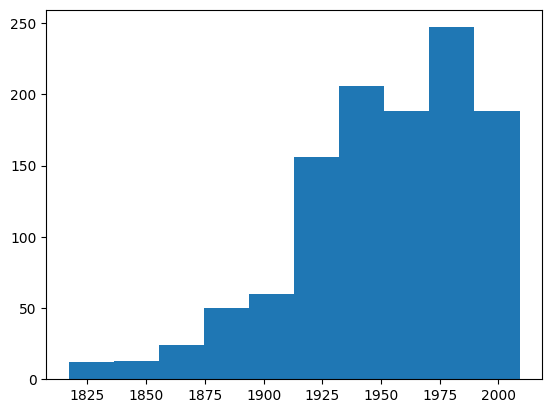

In [347]:
plt.hist([c.year for c in coha_docs])

(array([586.,   0.,   0., 424.,   0.,   0., 108.,   0.,   0.,  26.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

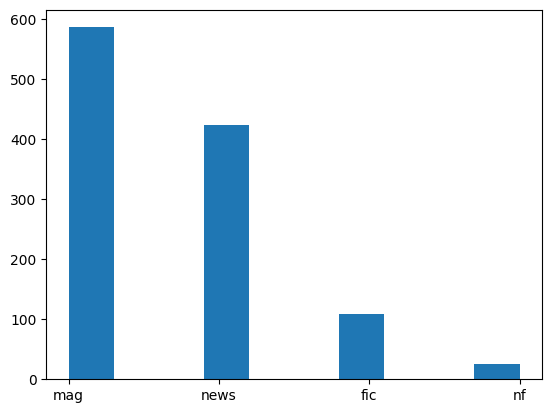

In [348]:
plt.hist([c.genre for c in coha_docs])

# Embeddings

## COHA

In [504]:
TERM1 = 'Amsterdam'
TERM2 = 'America'

In [507]:

from tqdm import tqdm


for f in tqdm(coha_docs, unit='doc'):
    if matches := f.find_sentences(TERM2):
        print(f)
        print(matches)


 18%|█▊        | 204/1144 [00:00<00:00, 1067.73doc/s]

mag_1865_528750.txt
['But an American woman can outdo the Duchess of Sutherland .', 'It is certainly enough to alarm ordinary amateurs , - and such are the most of us ; for , while Americans place all due stress upon the table , they neglect to emphasize the cuisine .', 'Is it strange that little Miss Bremer , who thought herself of soundest digestion , after three months of American night-dinners with oysters and preserve , is at last seen to grasp Dr. Osgood with both hands , exclaiming @ @ @ @ @ @ @ @ @ @ " I want to save you from resembling the great people of the world after the manner of Dr. Beattie , whose title to genius was , " Have I not headaches like Pope , vertigo like Swift , gray hairs like Homer ?']
fic_1979_10650.txt
["For a while he was polo coach at one of the Ivy League colleges , but it was not long before some of the school 's older alumni , considerable polo players themselves at one time and now on the board of trustees at their alma mater , denounced his presen

 66%|██████▌   | 751/1144 [00:00<00:00, 1511.10doc/s]

mag_1938_153950.txt
['<P> Last week most of the 2,000.000 U. S. amateur golfers , 90% of whom can not break 90 consistently , were reading with vicarious thrills the news of the nine Americans chosen to represent them in the tenth series of Walker Cup matches .']
mag_1950_230350.txt
['of America ( TIME , Apr. 30 , 1945 et seq. ) had all tested and proved the publicity value of fine art .', 'Last week a Manhattan liquor importing firm , Renfield Ltd. , was preparing to enter the same field in a small way with a traveling exhibition of twelve oils by the late , lusty , American-scene Painter George Luks .']
news_1951_713550.txt
['The major part of the bituminous coal industry today signed a " voluntary " agreement with the United Mine Workers of America for a wage increase of 20 cents an hour or $1.60 a day .', 'The agreement to stabilize labor relations for at least fourteen months and possibly longer , was announced in the office of John L. Lewis , president of the United Mine Workers 

100%|██████████| 1144/1144 [00:00<00:00, 1501.85doc/s]

nf_1829_747550.txt
['She was educated at the Academy in Bradford , a seminary which has become hallowed by her memory , and by that of Mrs. Newell , the proto-martyr of the American Missions .', 'The spirit of prayer and of exertion for the spread of the Gospel through the world , had not then been sufficiently diffused , to awaken the American churches to combined action for the support of foreign Missions .', 'We are not concerned to claim for him the exclusive honor A having led the way in originating the American Board of Commisdoners .', 'By the exertions of an American gentleman , he was released on parole , and at length with great difficalty he obftEtimed passports from the Emperor , and proceeded to England , where he arrived in May .', 'It was fiMind , that no concert of measores could be ranged ; bat the London Society agreed to Mr. J. and his companions as Missionaries if the American Board ahonld not be able to do it. * Mr. J. returned to America , and at the meeting of th

# Embeddings

In [508]:
import collections
from dataclasses import dataclass
from functools import cache
from itertools import islice
from typing import Iterable, List, Optional, Tuple
from transformers.pipelines.feature_extraction import FeatureExtractionPipeline

def sliding_window(iterable, n):
    # From https://docs.python.org/3/library/itertools.html#itertools-recipes
    # sliding_window('ABCDEFG', 4) --> ABCD BCDE CDEF DEFG
    it = iter(iterable)
    window = collections.deque(islice(it, n), maxlen=n)
    if len(window) == n:
        yield tuple(window)
    for x in it:
        window.append(x)
        yield tuple(window)


@dataclass
class Sentence:
    text: str
    coha_doc: CohaDoc
    model: FeatureExtractionPipeline

    def __contains__(self, s: str):
        return s in self.text

    @property
    def year(self) -> Optional[int]:
        return self.coha_doc.year

    @property
    def tokenizer(self):
        return self.model.tokenizer

    @cached_property
    def _embeddings(self):
        return self.model(self.text)[0]

    @cached_property
    def _token_ids(self):
        return self.tokenizer(self.text)['input_ids']

    def embeddings_matrix(self, token: str) -> List[np.array]:
        if token in self:
            return [
                self._aggregate_embeddings(token_i, token_length)
                for token_i, token_length in self._find_token(token, self._token_ids)
            ]
        else:
            logging.warning(f"Token '{token}' not found.")
            return None

    @staticmethod    
    def _find_token(token: str, token_ids: List[int], max_n: int = 5) -> Tuple[int, int]:
        """
        Find sequences of (sub-word) tokens that match a (word) token if merged

        Args:
            - token: a token (word) to find, exact match
            - token_ids: a sequence of token ids generated by a transformer tokenizer
            - max_n: the maximum number of sub-word tokens to be merged
        Yields: Tuple[int, int]: the token index and the length (number of tokens to be merged)
        """
        _tokens = model.tokenizer.convert_ids_to_tokens(token_ids)

        for n in range(max_n, 0, -1):
            for i, window in enumerate(sliding_window(_tokens, n)):
                _token = model.tokenizer.convert_tokens_to_string(window)
                if _token.strip() == token:
                    yield i, n

    def _aggregate_embeddings(self, token_start_index: int, token_length: int) -> np.array:
        if token_length == 1:
            return np.array(self._embeddings[token_start_index])
        else:
            return np.array(self._embeddings[token_start_index:token_start_index+token_length]).mean(axis=0)



In [452]:
import random

random.seed(0)

doc = random.choice(coha_docs)
s = random.choice(doc.sentences())

sentence = Sentence(s, doc, model)
print(sentence)

Sentence(text='He had had little involvement in politics and avoided the public spotlight , preferring instead to spend his free time tending the roses at his country home southwest of Paris .', coha_doc=mag_1986_333750.txt, model=<transformers.pipelines.feature_extraction.FeatureExtractionPipeline object at 0x7fdfe48f1390>)


In [456]:
np.array(sentence.embeddings_matrix('the')).shape

(2, 768)

In [509]:
term1_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in coha_docs
    for s in doc.find_sentences(TERM1)
]

term2_sentences: List[Sentence] = [
    Sentence(s, doc, model)
    for doc in coha_docs
    for s in doc.find_sentences(TERM2)
]

## Plot Embeddings

In [510]:
embeddings1 = []
for sentence in term1_sentences:
    embeddings1.extend(sentence.embeddings_matrix(TERM1))

In [512]:
np.array(embeddings1).shape

(31, 768)

In [511]:
embeddings2 = []
for sentence in term2_sentences:
    embeddings2.extend(sentence.embeddings_matrix(TERM2))

In [513]:
np.array(embeddings2).shape

(684, 768)

In [516]:
all_embeddings = embeddings1 + embeddings2
len(all_embeddings)

715

In [522]:
y = [TERM1] * len(embeddings1) + [TERM2] * len(embeddings2)

### PCA

In [517]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(all_embeddings)

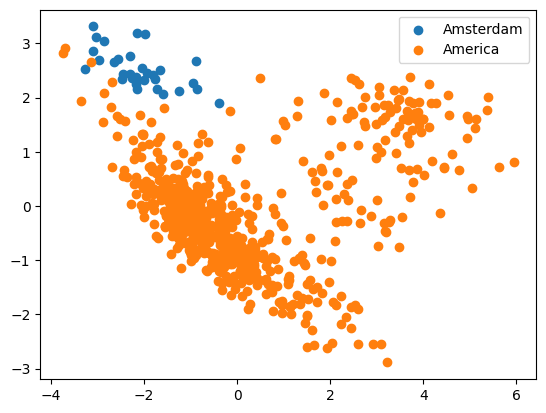

In [532]:
plt.scatter(pca[:len(embeddings1),0], pca[:len(embeddings1),1], label=TERM1)
plt.scatter(pca[len(embeddings1):,0], pca[len(embeddings1):,1], label=TERM2)
plt.legend()

### UMAP

In [530]:
from numba import core
import umap

X_umap = umap.UMAP().fit_transform(all_embeddings)


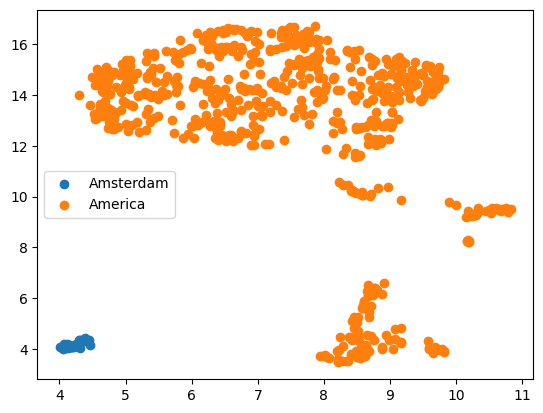

In [533]:
plt.scatter(X_umap[:len(embeddings1),0], X_umap[:len(embeddings1),1], label=TERM1)
plt.scatter(X_umap[len(embeddings1):,0], X_umap[len(embeddings1):,1], label=TERM2)
plt.legend()

# OLD

In [102]:
sentences = ["Duurzaamheid in een zin.", "Een andere zin met duurzaamheid.", "Hier staat iets anders."]

inputs = model.tokenizer(sentences)
tokens = [model.tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]
features = model(sentences)

In [ ]:
sentence_id = 2
token_id = 0

features[sentence_id][0][token_id]

In [100]:
#for i, token in enumerate(tokens):
    #tokenizer.convert_ids_to_tokens
    #print(token, features[i])

for i, sentence in enumerate(sentences):
    input_ids = features["input_ids"][i]

TypeError: list indices must be integers or slices, not str

In [236]:
import numpy as np
import torch

def sentence_embeddings(sentence: str):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)
    layers = outputs.hidden_states[-4:]
    return (inputs["input_ids"], torch.sum(layers))


In [247]:
inputs = tokenizer(sentence1, return_tensors="pt")
outputs = model(**inputs)
torch.sum(outputs.hidden_states[-4:])

TypeError: sum(): argument 'input' (position 1) must be Tensor, not tuple

In [237]:
from scipy.spatial.distance import cosine

sentence1 = "Duurzaamheid gaat over milieu"
sentence2 = "Duurzaamheid gaat over iets anders"

input_ids1, embeddings1 = sentence_embeddings(sentence1)
input_ids2, embeddings2 = sentence_embeddings(sentence2)

tokens1 = tokenizer.convert_ids_to_tokens(input_ids1[0])
tokens2 = tokenizer.convert_ids_to_tokens(input_ids2[0])

for i in range(embeddings1.shape[1]):
    print(tokens1[i], tokens2[i], cosine(embeddings1[0, i, :], embeddings2[0, i, :]))

#embeddings1[0, i, :].shape

TypeError: sum(): argument 'input' (position 1) must be Tensor, not tuple

# Text Generation

In [28]:
from transformers import pipeline

generator = pipeline(task="text-generation", model=MODEL_NAME)

In [32]:
generator("Duurzaamheid heeft te maken met milieu en klimaat.")

/Users/carstenschnober/opt/anaconda3/envs/SoS/lib/python3.10/site-packages/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 100 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': "Duurzaamheid heeft te maken met milieu en klimaat. En de mens is niet alleen gebaat bij een gezond voedselvoorziening, hij kan ook zijn eigen gezondheid schaden.'\n'We weten nu al dat we het leven in ons lichaam kunnen veranderen', zegt Van Raaij: 'Er wordt nog steeds veel onderzoek gedaan naar of er nieuwe aanwijzingen worden gevonden voor schadelijke stoffen als CO2 (regeringsbombardement), koolstofdioxide (zwaluwstof) en chlorofestonoxine (een"}]